In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from scipy import ndimage as nd
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import missingness as m
import GOES

In [3]:
data_fp = '/Volumes/SEAGATE/capsnet/'
tc_data = pd.read_csv(data_fp + 'tc_data.csv')

## Ditribution of pixel missingness fraction within IR imagery. 

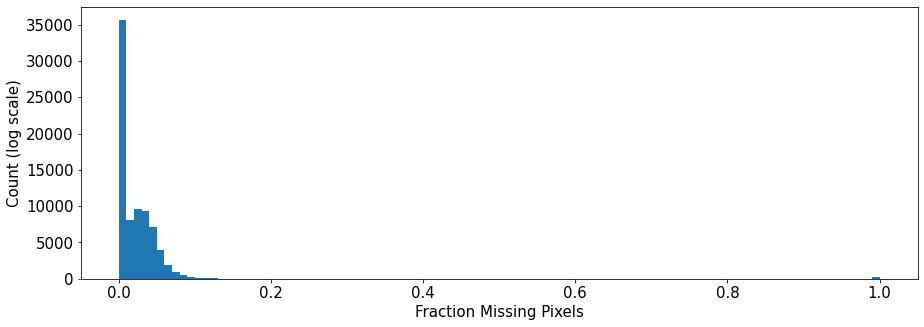

In [21]:
plt.rc('font', size=15)
plt.figure(figsize = (15, 5))
plt.hist(tc_data['nan_frac'].to_numpy(), bins = 100)
plt.xlabel('Fraction Missing Pixels')
plt.ylabel('Count (log scale)')
plt.show()

In [7]:
def quant(q):
    return np.round(tc_data['nan_frac'].quantile(q = q), 4)

for q in [0.5, 0.75, 0.9, 0.95, 0.99, 0.995]:
    print(f'{q} quantile: {quant(q)}')


0.5 quantile: 0.0145
0.75 quantile: 0.0356
0.9 quantile: 0.0509
0.95 quantile: 0.0617
0.99 quantile: 0.1001
0.995 quantile: 0.1453


For the analysis in this dataset, I'm keeping only images with missingness fraction of 7.5% or less. Examples below show this as a reasonable cutoff for reconstructing the missing pixels. I also cut out all images corresponding to storms at less than 35 kt. Here is a breakdown of the dataset sizes before and after this curdown:

In [5]:
NAN_FRAC_CUTOFF = 0.075
WIND_CUTOFF = 35
idx_to_delete = np.argwhere(((tc_data.nan_frac > NAN_FRAC_CUTOFF) | (tc_data.wind < WIND_CUTOFF)).to_numpy()).flatten()

n = tc_data.shape[0]
print(f'n (total): {n}')
print(f'n (post cleaning): {n - len(idx_to_delete)}')
print(f'Difference: {len(idx_to_delete)}')
print(f'Percent Removed: {round(100 * len(idx_to_delete)/n, 1)} %')

n (total): 78045
n (post cleaning): 71595
Difference: 6450
Percent Removed: 8.3 %


## A few examples of my filling procedure

In [14]:
def fill_pixels_example(GOES_filepath, id, time_idx, radius = 400):
    goes = GOES.Stamp.from_filename(GOES_filepath + id + '-half-hr-1000.nc')
    tst, nan_frac = m.stamp_at_time(goes, time_idx, radius)
    tst_mask = np.where(np.isnan(tst), 1, 0).astype('uint8')
    tst_paint = cv2.inpaint(tst, tst_mask, 1, cv2.INPAINT_NS)
    tst_fill = m.fill(tst_paint)
    tst_reshaped = cv2.resize(tst_fill, (200, 200), interpolation = cv2.INTER_AREA) # Reshape to 200x200, which is approx 4kmx4km resolution, since our stamps are 400km radius. So this reshape approximately matches the highest resolution satellite images we will get (near the equator).

    plt.rc('font', size=15)
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (13, 13))
    axs[0,0].imshow(tst)
    axs[0,0].set_title(f'1. Original; Missing {round(nan_frac, 3)}')
    axs[0,1].imshow(tst_paint)
    axs[0,1].set_title('2. OpenCV In-Paint')
    axs[1,0].imshow(tst_fill)
    axs[1,0].set_title('3. Nearest Neighbor Fill')
    axs[1,1].imshow(tst_reshaped)
    axs[1,1].set_title('4. Resized to 200x200')
    plt.show()

In [7]:
tc_data.reset_index(inplace = True, drop = True)

In [11]:
tc_data[(tc_data.nan_frac > 0.01) & (tc_data.nan_frac < 0.02)].head(5)

,ID,date,time_idx,wind,category,category_num,nan_frac
38,AL032000,2000-08-05 01:00:00,62,40.833333,TS,0,0.012330
39,AL032000,2000-08-05 01:30:00,63,41.250000,TS,0,0.013415
40,AL032000,2000-08-05 02:00:00,64,41.666667,TS,0,0.015512
41,AL032000,2000-08-05 02:30:00,65,42.083333,TS,0,0.016173
42,AL032000,2000-08-05 03:00:00,66,42.500000,TS,0,0.018390


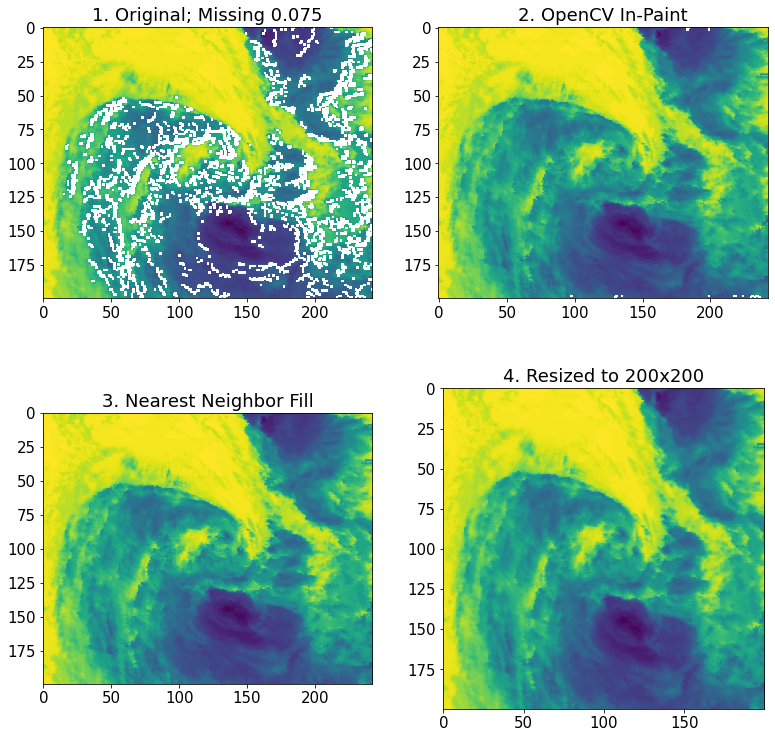

In [20]:
indices = [1866, 2548, 766, 71868, 77758, 282]

idx = indices[3]
id = tc_data.loc[idx].ID
time_idx = tc_data.loc[idx].time_idx
fill_pixels_example('/Volumes/SEAGATE/GOES/', id, time_idx)

In [15]:
# Is the missigness correlated with the phenomenon we're looking at.

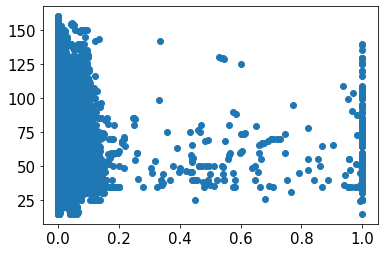

In [18]:
plt.scatter(tc_data.nan_frac, tc_data.wind)